# Deep Learning como Problema de Control Óptimo

Fabián U.

Set de datos: Donut 

In [1]:
import numpy as np 
import scipy as sc
import control
import sympy as sm
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import linprog, fsolve, minimize, LinearConstraint
from sklearn.datasets import make_moons, make_circles, make_classification
from scipy.optimize import minimize
import time

## Set de Datos

In [2]:
def plot_dataset(X, c, name):
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    ax.scatter(X[:, 0], X[:, 1], c=c, cmap="RdYlBu")
    ax.set_title(f"{name}")

In [3]:
n_datos = "donut"

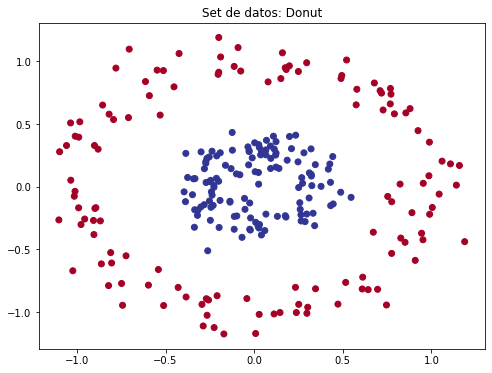

In [4]:
dataset = make_circles(n_samples=250, noise=0.1, factor=0.3, random_state=1)
plot_dataset(dataset[0], dataset[1], "Set de datos: Donut")
plt.savefig("data_"+n_datos+".jpg", bbox_inches='tight', )

In [5]:
x = dataset[0]
c = dataset[1]
x_train = dataset[0][0:150]
x_test = dataset[0][150::]
c_train = dataset[1][0:150]
c_test = dataset[1][150::]

## ResNet

### Funciones para minimizar J y calcular trayectoria mediante Euler

In [6]:
# Primer Aproach
N = 10  # capas de la red = 10

def C(x):
    return 1/(1+np.exp(-x))

# Activación actua componente a componente
def activacion(x):
    act = np.zeros(len(x))
    for i in range(len(x)):
        act[i] = np.tanh(x[i])
    return act

# Función f = sigma(Ky+b)
def f(K, beta, y):
    return activacion(np.dot(K, y) + beta)


def minimizar(U, x, c):
    m = len(x)
    n = len(x[0])
    y = np.zeros((N, m, n))
    y[0] = np.array(x)

    for j in range(m):
        for i in range(N-1):
            u = U[i*(n*n+n) : (i+1)*(n*n+n)]
            K1 = u[:n*n]
            K = np.reshape(K1, (n,n))
            beta = np.array(u[n*n:])
            y[i+1][j] = y[i][j] + f(K, beta, y[i][j])
            
    suma = 0
    y_N = y[N-1]
    W = U[len(U)-n-1: -1]
    mu = U[-1]
    for i in range(m):
        suma = suma + np.abs(C(np.dot(W, y_N[i]) + mu) - c[i])**2
    return suma

In [7]:
def Trayectoria1(U, x):
    k = len(x)
    n = len(x[0])
    y = np.zeros((N, k, n))
    y[0] = np.array(x)
    
    T = []
    for j in range(k):
        for i in range(N-1):
            u = U[i*(n*n+n) : (i+1)*(n*n+n)]
            K1 = u[:n*n]
            K = np.reshape(K1, (n,n))
            beta = np.array(u[n*n:])
            y[i+1][j] = y[i][j] +  f(K, beta, y[i][j])
        T.append(y[:,j,:])
    return T

In [8]:
def Trayectoria2(U, x):
    k = len(x)
    n = len(x[0])
    y = np.zeros((N, k, n))
    y[0] = np.array(x)
    T = [y[0,:,:]]
    for i in range(N-1):
        for j in range(k):
            u = U[i*(n*n+n) : (i+1)*(n*n+n)]
            K1 = u[:n*n]
            K = np.reshape(K1, (n,n))
            beta = np.array(u[n*n:])
            y[i+1][j] = y[i][j] + f(K, beta, y[i][j])
        T.append(y[i+1,:,:])
    return T

In [9]:
def Hipotesis(x, U):
    k = len(x)
    n = len(x[0])
    T = Trayectoria1(U, x)
    W = U[len(U)-n-1: -1]
    mu = U[-1]
    H = []
    for j in range(k):
        H.append((C(np.dot(W, np.array(T[j][N-1]))+mu)))
    return np.array(H)

In [10]:
def clasificador(x, U):
    k = len(x)
    n = len(x[0])
    Mapeo = []
    W = U[len(U)-n-1: -1]
    mu = U[-1]
    for i in range(k):
        Mapeo.append(C(np.dot(W, x[i]) + mu))
    return np.array(Mapeo)

### Funciones para graficar resultados

In [11]:
def plot_region(X, c, control, modelo=""):
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    step = 0.1
    x_min, x_max = X[:,0].min()-1, X[:,0].max()+1
    y_min, y_max = X[:,1].min()-1, X[:,1].max()+1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))
    Prediccion = Hipotesis(np.c_[xx.ravel(), yy.ravel()], control)
    Prediccion = Prediccion.reshape(xx.shape)
    cf = ax.contourf(xx, yy, Prediccion, cmap="RdYlBu", alpha=0.5)
    ax.scatter(X[:,0], X[:,1], c=c, cmap="RdYlBu")
    ax.set_title(modelo, fontsize=24)
    #fig.colorbar(cf, ax=ax)
    

In [12]:
def plot_tray(X, c, control, modelo=""):
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    T = np.array(Trayectoria2(control, X))
    k =len(X)
    x_min, x_max = 0, 0
    y_min, y_max = 0, 0
    for j in range(k):
        T_j = T[:,j,:]
        ax.plot(T_j[:, 0], T_j[:, 1], c=[plt.cm.RdYlBu.get_under(), plt.cm.RdYlBu.get_over()][c[j]], alpha=0.2, linewidth=1.5)
        x_min, x_max = min(T_j[:,0].min()-1, x_min), max(T_j[:,0].max()+1,x_max)
        y_min, y_max = min(T_j[:,1].min()-1, y_min), max(T_j[:,1].max()+1,y_max)
       
    ax.scatter(T[0][:, 0], T[0][:, 1], c=c, cmap="RdYlBu")
    ax.scatter(T[N-1][:, 0], T[N-1][:, 1], c=c, cmap="RdYlBu")
    step = 0.1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))
    Mapeo = clasificador(np.c_[xx.ravel(), yy.ravel()], control)
    Mapeo = Mapeo.reshape(xx.shape)
    cf = ax.contourf(xx, yy, Mapeo, cmap="RdYlBu", alpha=0.5)
    ax.set_title(modelo, fontsize=24)
    

### Minimización de J y obtención del Control óptimo.

In [13]:
#Condicion inicial
control_0 = []
for i in range(N-1):
    K = [1,0,0,1]
    be = [0,0]
    control_0 += K+be
      
W = [-1,1]
mu = [0]
control_0 += W+mu    
control_0 = np.array(control_0)
control_0

array([ 1,  0,  0,  1,  0,  0,  1,  0,  0,  1,  0,  0,  1,  0,  0,  1,  0,
        0,  1,  0,  0,  1,  0,  0,  1,  0,  0,  1,  0,  0,  1,  0,  0,  1,
        0,  0,  1,  0,  0,  1,  0,  0,  1,  0,  0,  1,  0,  0,  1,  0,  0,
        1,  0,  0, -1,  1,  0])

In [14]:
inicio = time.time()

sol = minimize(minimizar,control_0, args=(x_train, c_train))
co = sol.x

fin = time.time()
print("Tiempo de ejecucion: ", fin-inicio) 
print("Valor de J:", sol.fun)
print("Control optimo", co)

Tiempo de ejecucion:  138.9985375404358
Valor de J: 4.792902931451985e-07
Control optimo [-1.04586542  1.89768416  0.21418772  1.94253393 -2.170644   -1.67824441
  3.91133882  1.52208332  8.42848738 -5.43666442  2.46491268  7.40681124
  0.44827943 -0.54085459 -2.00589777  9.13772427  3.35473205  1.55260778
  1.83100751 -1.05778982 -3.97880357  8.60607745  1.95384488  0.04550226
  3.22316875 -1.65472586  2.63114792  5.65747495  1.47491628 -1.73140643
  1.03275269  0.06403731  3.03922437  2.4322326  -1.69687252 -1.1910153
  1.33115878  0.04239895  1.78649237  1.48471877 -0.39708346 -0.40293956
  1.09420922  0.24902213  2.65095092  1.01830115  0.09966317 -0.37405271
  1.04215948  0.09105807  1.4358267   1.15806087  0.02103531 -0.18381818
 -4.51934753  4.22380194 -9.41426855]


### Gráfico de Región de Decisión y Trayectoria

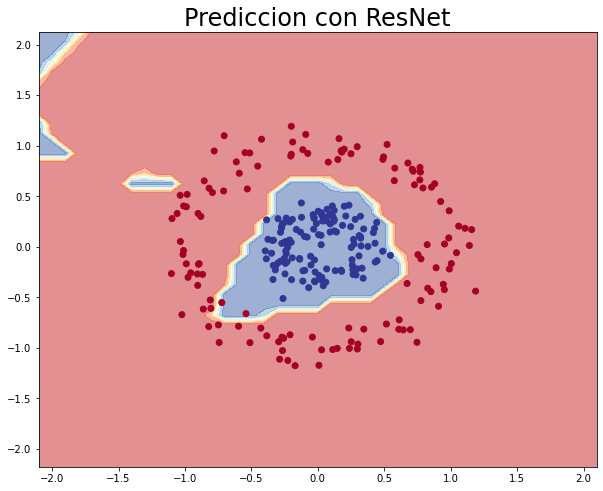

In [15]:
plot_region(x, c, co, modelo="Prediccion con ResNet")
plt.savefig("ResNet_"+n_datos+".jpg", bbox_inches='tight', )

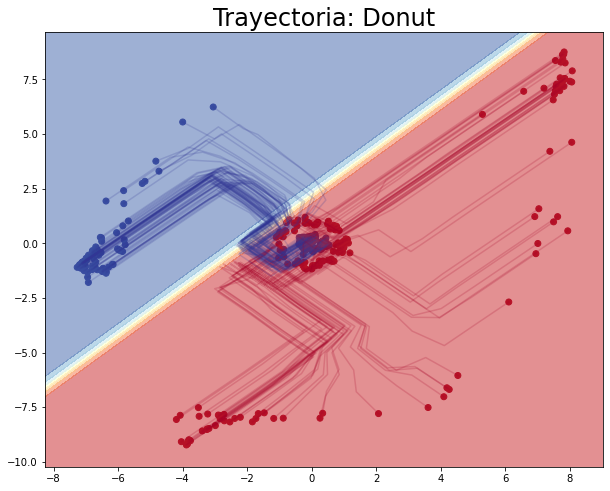

In [16]:
plot_tray(x_train, c_train, co, modelo="Trayectoria: Donut") 
plt.savefig("Tray_ResNet_"+n_datos+".jpg", bbox_inches='tight', )

### Tests y obtención de indicadores

In [17]:
inicio = time.time()

H = Hipotesis(x_test, co)

fin = time.time()
print("Tiempo de ejecucion: ", fin-inicio) 

Tiempo de ejecucion:  0.01150059700012207


In [18]:
hypot = []
for i in range(len(H)):
    if H[i]>0.5:
        hypot.append(1)
    else:
        hypot.append(0)
        
tn, fp, fn, tp = 0, 0, 0, 0
for i in range(len(H)):
    if c_test[i] == 1 and hypot[i] == 1:
        tp = tp +1
    elif c_test[i] == 1 and hypot[i] == 0:
        fn = fn +1
    elif c_test[i] == 0 and hypot[i] == 1:
        fp = fp +1
    elif c_test[i] == 0 and hypot[i] == 0:
        tn = tn +1

In [19]:
print('tn: ' + str(tn))
print('fp: ' + str(fp))
print('fn: ' + str(fn))
print('tp: ' + str(tp))

tn: 47
fp: 2
fn: 0
tp: 51


In [20]:
correctitud = (tp+tn)/float(tp+fp+fn+tn)
sensibilidad = (tp)/float(tp+fn)
especificidad = (tn)/float(fp+tn)
precision = (tp)/float(tp+fp)
f1_score = 2*(precision*sensibilidad)/float(precision+sensibilidad)

print("correctitud: " + str(np.round(correctitud*100,2)) + "%")
print("sensibilidad: " + str(np.round(sensibilidad*100,2)) + "%")
print("especificidad: " + str(np.round(especificidad*100,2)) + "%")
print("precision: " + str(np.round(precision*100,2)) + "%")
print("f1_score: " + str(np.round(f1_score*100,2)) + "%")

correctitud: 98.0%
sensibilidad: 100.0%
especificidad: 95.92%
precision: 96.23%
f1_score: 98.08%


## Árbol de Decisión

In [21]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix

In [22]:
ad = DecisionTreeClassifier()  # modelo

inicio = time.time()

ad.fit(x_train, c_train)  # Entrenar el modelo

fin = time.time()
print("Tiempo de ejecucion: ", fin-inicio) 

Tiempo de ejecucion:  0.0


In [23]:
inicio = time.time()

Y_pred = ad.predict(x_test)  # Predicción

fin = time.time()
print("Tiempo de ejecucion: ", fin-inicio)

Tiempo de ejecucion:  0.0


In [24]:
tn, fp, fn, tp = confusion_matrix(c_test, Y_pred).ravel()
print('tn: ' + str(tn))
print('fp: ' + str(fp))
print('fn: ' + str(fn))
print('tp: ' + str(tp))

tn: 49
fp: 0
fn: 2
tp: 49


In [25]:
correctitud = (tp+tn)/float(tp+fp+fn+tn)
sensibilidad = (tp)/float(tp+fn)
especificidad = (tn)/float(fp+tn)
precision = (tp)/float(tp+fp)
f1_score = 2*(precision*sensibilidad)/float(precision+sensibilidad)

print("correctitud: " + str(np.round(correctitud*100,2)) + "%")
print("sensibilidad: " + str(np.round(sensibilidad*100,2)) + "%")
print("especificidad: " + str(np.round(especificidad*100,2)) + "%")
print("precision: " + str(np.round(precision*100,2)) + "%")
print("f1_score: " + str(np.round(f1_score*100,2)) + "%")

correctitud: 98.0%
sensibilidad: 96.08%
especificidad: 100.0%
precision: 100.0%
f1_score: 98.0%


In [26]:
def plot_region_model(X, c, model, modelo=""):
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    step = 0.1
    x_min, x_max = X[:,0].min()-1, X[:,0].max()+1
    y_min, y_max = X[:,1].min()-1, X[:,1].max()+1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))
    Prediccion = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Prediccion = Prediccion.reshape(xx.shape)
    cf = ax.contourf(xx, yy, Prediccion, cmap="RdYlBu", alpha=0.5)
    ax.scatter(X[:,0], X[:,1], c=c, cmap="RdYlBu")
    ax.set_title(modelo, fontsize=24)
    #fig.colorbar(cf, ax=ax)

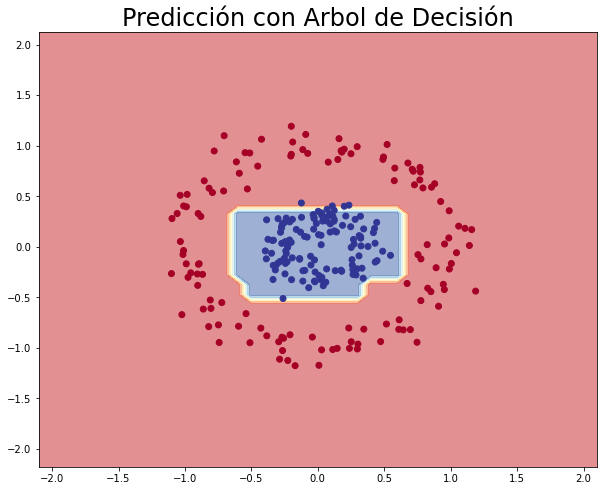

In [27]:
plot_region_model(x, c, ad, modelo="Predicción con Arbol de Decisión")
plt.savefig("ad_"+n_datos+".jpg", bbox_inches='tight', )

## Analisis del Discriminante Cuadrático

In [28]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [29]:
qda = QuadraticDiscriminantAnalysis()  # modelo

inicio = time.time()

qda.fit(x_train, c_train)  # Entrenar el modelo

fin = time.time()
print("Tiempo de ejecucion: ", fin-inicio) 

Tiempo de ejecucion:  0.00859689712524414


In [30]:
inicio = time.time()

Y_pred = qda.predict(x_test)  # Predicción

fin = time.time()
print("Tiempo de ejecucion: ", fin-inicio)

Tiempo de ejecucion:  0.0


In [31]:
tn, fp, fn, tp = confusion_matrix(c_test, Y_pred).ravel()
print('tn: ' + str(tn))
print('fp: ' + str(fp))
print('fn: ' + str(fn))
print('tp: ' + str(tp))

tn: 49
fp: 0
fn: 1
tp: 50


In [32]:
correctitud = (tp+tn)/float(tp+fp+fn+tn)
sensibilidad = (tp)/float(tp+fn)
especificidad = (tn)/float(fp+tn)
precision = (tp)/float(tp+fp)
f1_score = 2*(precision*sensibilidad)/float(precision+sensibilidad)

print("correctitud: " + str(np.round(correctitud*100,2)) + "%")
print("sensibilidad: " + str(np.round(sensibilidad*100,2)) + "%")
print("especificidad: " + str(np.round(especificidad*100,2)) + "%")
print("precision: " + str(np.round(precision*100,2)) + "%")
print("f1_score: " + str(np.round(f1_score*100,2)) + "%")

correctitud: 99.0%
sensibilidad: 98.04%
especificidad: 100.0%
precision: 100.0%
f1_score: 99.01%


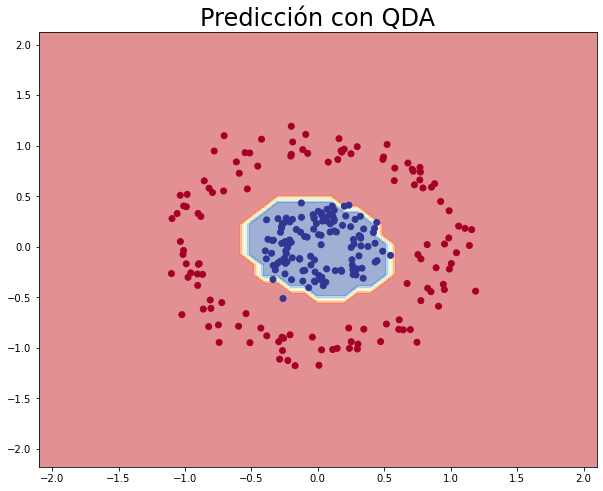

In [33]:
# funcion anterior de AD sirve 
plot_region_model(x, c, qda, modelo="Predicción con QDA")
plt.savefig("qda_"+n_datos+".jpg", bbox_inches='tight', )

### SVC

In [34]:
from sklearn.svm import SVC

In [35]:
svc = SVC(random_state=1)

inicio = time.time()

svc.fit(x_train, c_train)

fin = time.time()
print("Tiempo de ejecucion: ", fin-inicio) 

Tiempo de ejecucion:  0.0052111148834228516


In [36]:
inicio = time.time()

Y_pred = svc.predict(x_test)  # Predicción

fin = time.time()
print("Tiempo de ejecucion: ", fin-inicio)

Tiempo de ejecucion:  0.0


In [37]:
tn, fp, fn, tp = confusion_matrix(c_test, Y_pred).ravel()
print('tn: ' + str(tn))
print('fp: ' + str(fp))
print('fn: ' + str(fn))
print('tp: ' + str(tp))

tn: 49
fp: 0
fn: 0
tp: 51


In [38]:
correctitud = (tp+tn)/float(tp+fp+fn+tn)
sensibilidad = (tp)/float(tp+fn)
especificidad = (tn)/float(fp+tn)
precision = (tp)/float(tp+fp)
f1_score = 2*(precision*sensibilidad)/float(precision+sensibilidad)

print("correctitud: " + str(np.round(correctitud*100,2)) + "%")
print("sensibilidad: " + str(np.round(sensibilidad*100,2)) + "%")
print("especificidad: " + str(np.round(especificidad*100,2)) + "%")
print("precision: " + str(np.round(precision*100,2)) + "%")
print("f1_score: " + str(np.round(f1_score*100,2)) + "%")

correctitud: 100.0%
sensibilidad: 100.0%
especificidad: 100.0%
precision: 100.0%
f1_score: 100.0%


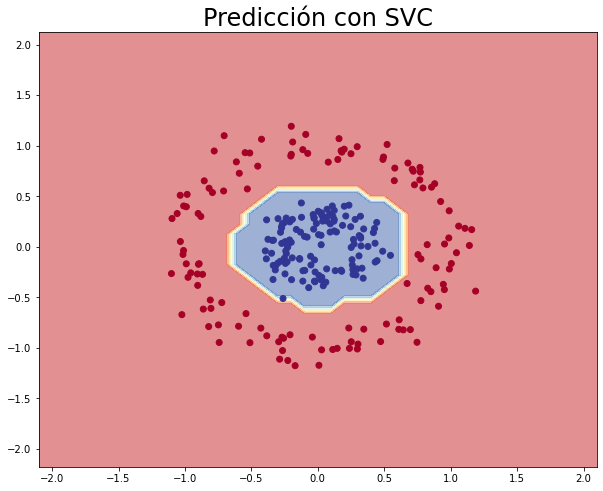

In [39]:
# funcion anterior de AD sirve 
plot_region_model(x, c, svc, modelo="Predicción con SVC")
plt.savefig("svc_"+n_datos+".jpg", bbox_inches='tight', )

## Multi-layer Perceptron classifier

In [40]:
from sklearn.neural_network import MLPClassifier

In [41]:
mlp = MLPClassifier(alpha=1, hidden_layer_sizes=(10,10,10,10,10), max_iter=1000, random_state=0)
inicio = time.time()

mlp.fit(x_train, c_train)

fin = time.time()
print("Tiempo de ejecucion: ", fin-inicio) 

Tiempo de ejecucion:  0.4901459217071533


In [42]:
inicio = time.time()

Y_pred = mlp.predict(x_test)  # Predicción

fin = time.time()
print("Tiempo de ejecucion: ", fin-inicio)

Tiempo de ejecucion:  0.0


In [43]:
tn, fp, fn, tp = confusion_matrix(c_test, Y_pred).ravel()
print('tn: ' + str(tn))
print('fp: ' + str(fp))
print('fn: ' + str(fn))
print('tp: ' + str(tp))

tn: 49
fp: 0
fn: 0
tp: 51


In [44]:
correctitud = (tp+tn)/float(tp+fp+fn+tn)
sensibilidad = (tp)/float(tp+fn)
especificidad = (tn)/float(fp+tn)
precision = (tp)/float(tp+fp)
f1_score = 2*(precision*sensibilidad)/float(precision+sensibilidad)

print("correctitud: " + str(np.round(correctitud*100,2)) + "%")
print("sensibilidad: " + str(np.round(sensibilidad*100,2)) + "%")
print("especificidad: " + str(np.round(especificidad*100,2)) + "%")
print("precision: " + str(np.round(precision*100,2)) + "%")
print("f1_score: " + str(np.round(f1_score*100,2)) + "%")

correctitud: 100.0%
sensibilidad: 100.0%
especificidad: 100.0%
precision: 100.0%
f1_score: 100.0%


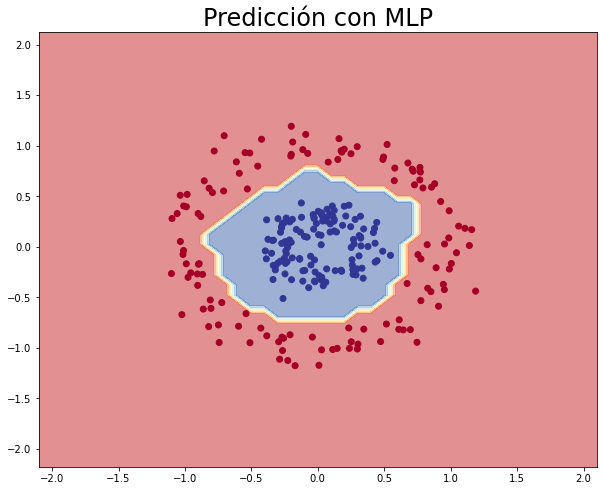

In [45]:
# funcion anterior de AD sirve 
plot_region_model(x, c, mlp, modelo="Predicción con MLP")
plt.savefig("mlp_"+n_datos+".jpg", bbox_inches='tight', )

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=b8d3a167-3fd1-499d-84a9-cd59b272742a' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>